In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import torch

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-tsv/new_train.tsv
/kaggle/input/test-tsv/new_test.tsv
/kaggle/input/tensorboardx/tensorboardx-2.6.4-py3-none-any.whl


In [15]:
#读入数据
import pandas as pd
train_df = pd.read_csv("/kaggle/input/train-tsv/new_train.tsv",
                       sep="\t", names=['text', 'label']) 
test_df = pd.read_csv("/kaggle/input/test-tsv/new_test.tsv", 
                       sep='\t', names=['text', 'label'])
train_df.head()
test_df.head()

#划分数据集
from sklearn.model_selection import train_test_split
train_texts, valid_texts, train_labels, valid_labels = train_test_split(
    train_df["text"], train_df["label"], test_size=0.2, random_state=42
)

#文本预处理
import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()

# ----------- BoW 方法 ------------
def build_bow(sentences, vocab=None):
    # 如果没有传 vocab，说明是训练集，需要自己构建
    if vocab is None:
        vocab = {}
        for sent in sentences:
            tokens = preprocess_text(sent)
            for word in tokens:
                if word not in vocab:
                    vocab[word] = len(vocab)

    bow_matrix = torch.zeros(len(sentences), len(vocab), dtype=torch.float32)
    for i, sent in enumerate(sentences):
        tokens = preprocess_text(sent)
        for word in tokens:
            if word in vocab:  # 只统计在 vocab 里的词
                bow_matrix[i][vocab[word]] += 1

    return bow_matrix, vocab


# ----------- N-gram 方法 ------------
def build_ngram_bow(sentences, n=2, vocab=None):
    if vocab is None:
        vocab = {}
        for sent in sentences:
            tokens = preprocess_text(sent)
            ngrams = generate_ngrams(tokens, n)
            features = tokens + ngrams
            for word in features:
                if word not in vocab:
                    vocab[word] = len(vocab)

    bow_matrix = torch.zeros(len(sentences), len(vocab), dtype=torch.float32)
    for i, sent in enumerate(sentences):
        tokens = preprocess_text(sent)
        ngrams = generate_ngrams(tokens, n)
        features = tokens + ngrams
        for word in features:
            if word in vocab:
                bow_matrix[i][vocab[word]] += 1

    return bow_matrix, vocab

# #----------bow方法--------------
# # 训练集（建立词表）
# X_train_bow, vocab = build_bow(train_texts)

# # 验证集（用训练集词表，不新建）
# X_valid_bow, _ = build_bow(valid_texts, vocab)

# # 测试集（同理）
# X_test_bow, _ = build_bow(test_df["text"], vocab)

#------------n-gram方法------------------
X_train_bow, vocab = build_ngram_bow(train_texts, n=2)
X_valid_bow, _ = build_ngram_bow(valid_texts, n=2, vocab=vocab)
X_test_bow, _  = build_ngram_bow(test_df["text"], n=2, vocab=vocab)


#标签转化为向量
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.long)
y_valid_tensor = torch.tensor(valid_labels.values, dtype=torch.long)
y_test_tensor = torch.tensor(test_df["label"].values, dtype=torch.long)

#检查一下
print("训练集:", X_train_bow.shape, y_train_tensor.shape)
print("验证集:", X_valid_bow.shape, y_valid_tensor.shape)
print("测试集:", X_test_bow.shape, y_test_tensor.shape)

训练集: torch.Size([6822, 79584]) torch.Size([6822])
验证集: torch.Size([1706, 79584]) torch.Size([1706])
测试集: torch.Size([3309, 79584]) torch.Size([3309])


In [19]:

from torch.utils.data import DataLoader, TensorDataset

#把特征 X_train_tensor 和标签 y_train_tensor 打包在一起
train_dataset = TensorDataset(X_train_bow, y_train_tensor)
valid_dataset = TensorDataset(X_valid_bow, y_valid_tensor)
test_dataset = TensorDataset(X_test_bow, y_test_tensor)

#为数据集划分batch，按batch读取TensorDataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

#前向传播
def forward(X, W, b):
    logits = X @ W + b  #线性层
    probs = torch.softmax(logits, dim=1)  #在类别数量维度上做softmax
    return probs

#损失函数
def cross_entropy_loss(probs, y):
    batch_size = y.size(0) #y为真实标签
    real_probs = probs[range(batch_size), y] + 1e-9 #从每一行的概率分布里，挑出真实类别对应的概率
    loss = -torch.log(real_probs).mean() #计算batch里面每一行的loss，并求均值
    return loss

#计算准确率
def accuracy(probs, y):
    preds = probs.argmax(dim=1)
    return (preds==y).float().mean().item()


In [ ]:
#!pip install /kaggle/input/tensorboardx/tensorboardx-2.6.4-py3-none-any.whl


In [ ]:
#import tensorboardX
#print(tensorboardX.__version__)


In [ ]:
#from tensorboardX import SummaryWriter

#writer = SummaryWriter()

#%load_ext tensorboard

#%load_ext tensorboard

In [22]:
#初始化参数

#行数=词表大小 列数=标签种类的个数
W_row = X_train_bow.shape[1]
W_col = len(set(train_labels))

W = torch.randn(W_row, W_col, dtype=torch.float32, requires_grad=True)
b = torch.zeros(W_col, dtype=torch.float32, requires_grad=True)

num_classes = W_col
lr = 0.01

print(f"共有 {num_classes} 种标签")
# 初始化列表
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

num_epochs = 10
for epoch in range(num_epochs):
    W.grad = None
    b.grad = None  # 清空梯度

    # ----------训练---------
    train_loss = 0
    train_acc = 0
    for X_batch, y_batch in train_loader:
        batch_size = X_batch.size(0)
        probs = forward(X_batch, W, b)
        loss = cross_entropy_loss(probs, y_batch)

        loss.backward()  # 反向传播

        # 参数更新
        with torch.no_grad():
            W -= lr * W.grad
            b -= lr * b.grad
            W.grad.zero_()
            b.grad.zero_()

        train_loss += loss.item() * batch_size
        train_acc += accuracy(probs, y_batch) * batch_size

    # ------验证--------
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            batch_size = X_batch.size(0)
            probs = forward(X_batch, W, b)
            loss = cross_entropy_loss(probs, y_batch)
            valid_loss += loss.item() * batch_size
            valid_acc += accuracy(probs, y_batch) * batch_size

    # 计算平均值
    train_loss /= len(train_dataset)
    valid_loss /= len(valid_dataset)
    train_acc /= len(train_dataset)
    valid_acc /= len(valid_dataset)

    # 保存到列表
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Valid Loss: {valid_loss:.4f} "
          f"Valid Acc: {valid_acc:.4f}")

#-----------测试-------------
test_loss = 0;
test_acc = 0;
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        batch_size = X_batch.size(0)
        probs = forward(X_batch, W, b)
        loss = cross_entropy_loss(probs, y_batch)
        test_loss += loss.item() * batch_size
        test_acc += accuracy(probs, y_batch) * batch_size

test_loss /= len(test_dataset)
test_acc /= len(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


共有 5 种标签
Epoch 1/10 Train Loss: 6.6295 Train Acc: 0.2150 Valid Loss: 5.9715 Valid Acc: 0.1928
Epoch 2/10 Train Loss: 6.3972 Train Acc: 0.2199 Valid Loss: 5.7641 Valid Acc: 0.1999
Epoch 3/10 Train Loss: 6.2036 Train Acc: 0.2256 Valid Loss: 5.5949 Valid Acc: 0.2057
Epoch 4/10 Train Loss: 6.0452 Train Acc: 0.2320 Valid Loss: 5.4630 Valid Acc: 0.2098
Epoch 5/10 Train Loss: 5.9188 Train Acc: 0.2357 Valid Loss: 5.3638 Valid Acc: 0.2163
Epoch 6/10 Train Loss: 5.8200 Train Acc: 0.2395 Valid Loss: 5.2907 Valid Acc: 0.2169
Epoch 7/10 Train Loss: 5.7430 Train Acc: 0.2432 Valid Loss: 5.2363 Valid Acc: 0.2169
Epoch 8/10 Train Loss: 5.6820 Train Acc: 0.2468 Valid Loss: 5.1955 Valid Acc: 0.2192
Epoch 9/10 Train Loss: 5.6327 Train Acc: 0.2493 Valid Loss: 5.1641 Valid Acc: 0.2181
Epoch 10/10 Train Loss: 5.5918 Train Acc: 0.2521 Valid Loss: 5.1385 Valid Acc: 0.2210
Test Loss: 5.0385, Test Acc: 0.2357


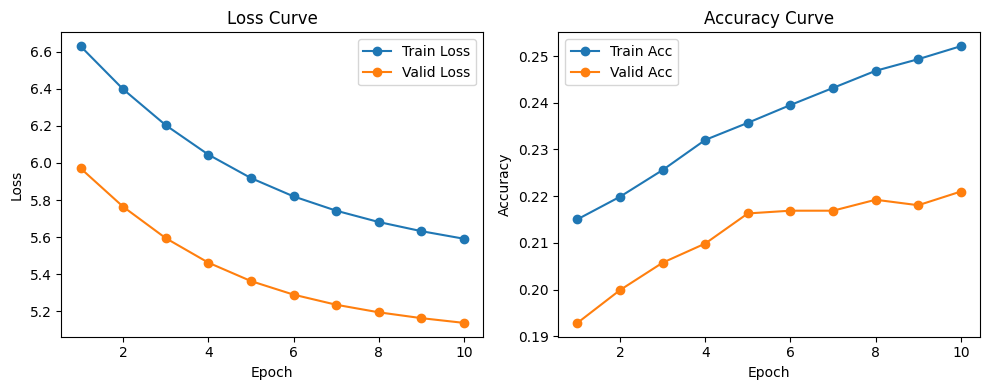

In [23]:
#-------------结果可视化---------------

import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Acc', marker='o')
plt.plot(epochs, valid_accs, label='Valid Acc', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()
